<a href="https://colab.research.google.com/github/maggawron/portfolio-rebalancing/blob/main/Portfolio_analysis_%26_rebalancing_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Portfolio analysis & rebalancing tool** *by Magdalena Gawron*


In [1]:
#@title Imports
import pandas as pd
import numpy as np
import math
import random
import copy

pd.options.display.float_format = "{:,.1f}".format

#Module for files upload from local drive
from google.colab import files
import io

import urllib.request

#Module to get asset price data
!pip install yfinance
import yfinance as yf

#Module to get currency pairs exchange rates
!pip install yahoofinancials
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
import matplotlib as mpl

#Clear the output
from IPython.display import clear_output 
clear_output()

#Portfolio class
Run this cell to set up the portfolio class.
No input is needed.

In [122]:
#@title Define Portfolio class
class Portfolio():
  def __init__(self, currency):
    self.default_cur = currency
    self.asset_columns = ["Category", "Subcategory", "Ticker", "Name", "Currency", 
                          "Quantity", "Unit_Value", "Value in original currency", 
                          "Value in " + self.default_cur, "Source", "Divisible", "Rebalancable", "Predefined_share"]
    self.assets_list = pd.DataFrame(columns=self.asset_columns)
    self.target_allocations = None


  def add_asset(self, category, subcategory, ticker, name, currency, amount, 
                unit_value, divisible=False, rebalancable=True, predefined_share=None):
    """method for addiction of an asset class via Python tool"""
    """least recommended option"""
    new_line = pd.DataFrame(np.array([[category, subcategory, ticker, 
                                       name, currency, amount, unit_value,  
                                       np.nan, np.nan, "Manual", divisible, rebalancable, predefined_share]]), 
                            columns=self.asset_columns)
    new_line = self.recalculate_values(new_line)  
    self.assets_list = pd.concat([self.assets_list, new_line])


  def utility_upload(self, input_info):
    """utility method for uploading csv files directly from a local drive or links"""
    if input_info is None:
      raise ValueError("No file has been passed")
    try:
      data = urllib.request.urlopen(input_info)
      return data
    except: 
      uploaded = files.upload()
      data = io.BytesIO(uploaded[input_info])
      return data
    else:
      raise ValueError("File could not be read")   

  def upload_target_allocations(self, file_input=None):
    """method for uploading target asset allocations, checking if they sum up to 100%"""
    data = self.utility_upload(file_input)
    self.target_allocations = pd.read_csv(data, skiprows=4, sep=";", decimal=",")

    self.target_allocations.astype({'Target_Allocation': 'float32'}).dtypes
    sum_allocations = self.target_allocations.Target_Allocation.sum()
    assert sum_allocations == 100, print(f'Your sum of all allocations should be 100%, now is {sum_allocations}%')
    

  def upload_asset_allocations(self, file_input=None):
    """method to uploading all asset data except for assets on Interactive Brokers"""
    data = self.utility_upload(file_input)
    assets_df = pd.read_csv(data, sep=";")    
    assets_df.insert(loc=7, column="Value in original currency", value=np.nan)
    assets_df.insert(loc=8, column="Value in " + self.default_cur, value=np.nan)
    assets_df.insert(loc=9, column="Source", value="Excel upload")
    assets_df = self.recalculate_values(assets_df)
    self.assets_list = pd.concat([self.assets_list, assets_df], ignore_index=True)


  def upload_IB_file(self, file_input, mapping_input, cash_category = "Cash", cash_subcategory = "Electronic"):
    """method for uploading Interactive Brokers MTM report into the tool"""
    """while uploading next version of the report, old is being discarded"""
    self.assets_list.drop(self.assets_list[self.assets_list.Source == "IB upload"].index, inplace=True)
    
    def get_skip_lines(lines):
      """function to parse the IB report to get the starting row"""
      lines_copy = copy.deepcopy(lines)
      for i, line in enumerate(lines_copy):
        line = str(line)
        if line[0] == 'b':
          line = line[2:]
        if line.split(" ")[0] == "Positions":
          return i
  
    data = self.utility_upload(file_input)
    skip_lines = get_skip_lines(data)
    df = pd.read_csv(data, skiprows=skip_lines)
    
    map_data = self.utility_upload(mapping_input)
    ticker_mapping = pd.read_csv(map_data, sep=";")
        
    ######Load tradable assets from IB
    df_stocks = df[df["Asset Class"].astype(str).str[:5] == "Stock"]
    
    #Rename columns
    col_mapper = {"Symbol":"Ticker", "Description": "Name"} 
    df_stocks = df_stocks.rename(columns=col_mapper)
    
    #Alternative backup data from mapping file (YF ticker and price)
    mapping_price = dict(zip(df_stocks.Ticker, df_stocks["Market Value"])) 
    mapping_ticker = dict(zip(ticker_mapping.Ticker, ticker_mapping.YF_Ticker))   
    df_stocks = df_stocks.loc[:, ["Ticker", "Name", 'Currency',"Quantity"]]
    
    #Add data to df_stocks
    for i in range(6,9):
      df_stocks.insert(loc=i-2, column=self.asset_columns[i], value=np.nan)
    df_stocks['Source'] = "IB upload"

    #Specify mapping columns order from ticker_mapping
    mapping_all_stocks = {0: "Category", 1: "Subcategory", 10: "Divisible", 
                          11: "Rebalancable", 12: "Predefined_share"}
    
    for j, v in mapping_all_stocks.items():
      hash_map = dict(zip(ticker_mapping.Ticker, ticker_mapping[v]))
      df_stocks.insert(loc=j, column=self.asset_columns[j], value=df_stocks.Ticker.map(hash_map))
    
    #Recalculate market value & add to assets_list
    df_stocks = self.recalculate_values(df_stocks, mapping_ticker, mapping_price)
    self.assets_list = pd.concat([self.assets_list, df_stocks], ignore_index=True)
    
    ########Load cash from IB    
    df_forex = df[df["Asset Class"].astype(str).str[:5] == "Forex"]
    df_forex = df_forex.drop(df_forex[df_forex.Quantity < 1].index)
    df_forex = df_forex.loc[:, ["Symbol", "Quantity"]]
    
    col_mapper = {"Symbol":"Currency"} 
    df_forex = df_forex.rename(columns=col_mapper)
    df_forex['Name'] = "Cash in IB in " + df_forex.Currency 
    df_forex = df_forex.loc[:, ["Name", "Currency", 'Quantity']]

    #Specify mapping order & map columns
    mapping_forex = {0: cash_category, 1: cash_subcategory, 2: np.nan, 6: 1, 
                     7: np.nan, 8: np.nan, 9:"IB upload", 10: True, 11: True}
    
    for j, v in mapping_forex.items():
      df_forex.insert(loc=j, column=self.asset_columns[j], value=v)
    
    #Recalculate market values & add to assets_list
    df_forex = self.recalculate_values(df_forex)
    self.assets_list = pd.concat([self.assets_list, df_forex], ignore_index=True) 
    

  def recalculate_values(self, df, ticker_map=None, price_map=None):
    """method fetching current asset prices based on tickers 
    and standardizing value to a default currency"""

    #Reset all indexes
    df.reset_index(inplace=True, drop=True)

    #Ensure passed dataframe has expected columns
    for c1, c2 in zip(df.columns, self.asset_columns):
      assert c1==c2, print(f'Columns: {df.columns} not matching, should be: {self.asset_columns}')
    
    #Try to match prices & names of assets for assets with tickers
    for i,ticker in enumerate(df.Ticker):
      try:
        if df.iloc[i, 4] != "USD" and ticker_map is not None:
          ticker = ticker_map[ticker]
        obj = yf.Ticker(ticker)
        inf = obj.info
        name = inf['shortName']
        price = inf['previousClose']
        df.iloc[i, 3] = name
        df.iloc[i, 6] = price
      except:
        pass

    #Check if any unit_value is missing after fetching from YFinance
    #In case it is missing, map price from IB report
    missing_values = df.loc[:, ['Ticker', "Unit_Value"]]
    missing_values = missing_values[missing_values['Ticker'].notna()]
    if len(missing_values) > 0:
      missing_values = missing_values[missing_values['Unit_Value'].isna()]
      if len(missing_values) > 0:
        print("The following assets cannot be found on Yahoo Finance")
        print(missing_values["Ticker"].values)
        print("Using static price from IB file, please validate YF_Ticker in IB mapping")
        for row in missing_values.iterrows():
          r = row[1]
          ti = r["Ticker"]
          price = price_map[ti]
          ind = df[df['Ticker'] == ti].index.values[0]
          df.iloc[ind, 6] = price
    
    #Calculate value of each portfolio position in original currency & portfolio currency
    ex_rates_map = {}
    for i in range(len(df)):
      df.iloc[i, 7] = float(df.iloc[i, 5]) * float(df.iloc[i, 6])
      ex_rate = 1
      source_cur = df.iloc[i, 4] 
      if source_cur != self.default_cur:
        if source_cur not in ex_rates_map:
          currency_ticker = self.default_cur + source_cur + '=X'
          yahoo_financials = YahooFinancials(currency_ticker)
          ex_rate = float(yahoo_financials.get_summary_data()[currency_ticker]['previousClose'])
          ex_rates_map[source_cur] = ex_rate
        else:
          ex_rate = ex_rates_map[source_cur]
      df.iloc[i, 8] = float(df.iloc[i, 7] / ex_rate)  
    return df

  def rebalance(self, rebalancing_style="proportional", leftover_cat="Cash", leftover_subcat="Electronic", min_delta=1000):
    """method for calculation of the asset flows to achieve target portfolio allocation"""

    #Check if all assets have total value calculated
    cal_nan = self.assets_list["Value in " + self.default_cur].isnull().sum()
    assert cal_nan == 0, print(f"{cal_nan} of your assets have a missing value")
    
    #Check how much in reality can be rebalanced per group
    sum_reb = self.assets_list.loc[self.assets_list["Rebalancable"] == True]
    sum_reb_gr = sum_reb.groupby(by=["Category", "Subcategory"]).sum()
    reb_mapping = dict(zip(sum_reb_gr.index, sum_reb_gr["Value in " + self.default_cur]))
    
    #Aggregate all the assets by category & subcategory
    new = self.assets_list.drop(columns=['Currency', 'Name', 'Value in original currency', "Unit_Value", 'Source'])
    pre_reb_gr = new.groupby(by=["Category", "Subcategory"]).sum()
    total_assets = pre_reb_gr["Value in " + self.default_cur].sum()
    pre_reb_gr['Percentage_Share'] = pre_reb_gr["Value in " + self.default_cur] / total_assets * 100
    pre_reb_gr["Value_For_Rebalance"] = pre_reb_gr.index.map(reb_mapping).fillna(0)
    pre_reb_gr.reset_index(inplace=True)


    #Check if all categories & subcategories have a match in self.target_allocations
    tar_all_set = set([a+" - "+b for a, b in zip(self.target_allocations.Category, self.target_allocations.Subcategory)])
    mer_assets_set = set([a+" - "+b for a, b in zip(pre_reb_gr.Category, pre_reb_gr.Subcategory)])
    assert mer_assets_set.issubset(tar_all_set), print(f"These categories of assets have unassigned target allocations: {mer_assets_set.difference(tar_all_set)}")
    not_matched_assets = tar_all_set.difference(mer_assets_set)
    if len(not_matched_assets) != 0:
      print(f"WARNING: These asset categories are not represented in your list of assets:")
      print(f"{not_matched_assets}")
      print(f"Note that they will be skipped in rebalancing with their share allocated to {leftover_cat + leftover_subcat}")

    #Left join target_allocations with grouped assets_list
    merged_df = pd.merge(self.target_allocations, pre_reb_gr, on=["Category", "Subcategory"], how="left").fillna(0)
    
    #Place category & subcategory handling leftovers at the end of the merged_df
    last_row_index = merged_df[(merged_df.Category == leftover_cat) & (merged_df.Subcategory == leftover_subcat)].index.values[0]
    reindex = list(range(len(merged_df)))
    reindex.remove(last_row_index)
    reindex.append(last_row_index)
    merged_df = merged_df.reindex(reindex)
    merged_df.reset_index(inplace=True, drop=True)
    conditions = [(abs(merged_df["Target_Allocation"] - merged_df["Percentage_Share"])) >= merged_df["Tollerance_pp"], 
                  (abs(merged_df["Target_Allocation"] - merged_df["Percentage_Share"])) < merged_df["Tollerance_pp"]]
    
    values = [(merged_df["Target_Allocation"] - merged_df["Percentage_Share"])/100 * total_assets, 0]

    merged_df["Buy_Sell_Need"] = np.select(conditions, values)
    merged_df = merged_df[merged_df["Value_For_Rebalance"] != 0]
    
    #Check if there is enough liquidity to buy
    sell_capacity = merged_df[merged_df["Buy_Sell_Need"] < 0]["Buy_Sell_Need"].sum()
    buy_need = merged_df[merged_df["Buy_Sell_Need"] > 0]["Buy_Sell_Need"].sum()
    
    if buy_need == 0:
      print(f"Cannot do any rebalancing as no buyable assets are rebalancable")
    elif sell_capacity == 0:
      print(f"Cannot do any rebalancing as no assets are available for sale")
    else:
      
      #If not, correct all buy budgets
      if float(buy_need) > float(sell_capacity):
        correct_ratio = -(sell_capacity / buy_need)
        print(f"Only {-sell_capacity:1.0f} {self.default_cur} is available to sell, vs. {buy_need:1.0f} {self.default_cur} to buy, correcting all assets to buy to {correct_ratio*100.:1.1f}% of original value")
        merged_df.loc[merged_df["Buy_Sell_Need"] > 0, "Buy_Sell_Need"] *= correct_ratio 

      cols = ["Category", "Subcategory", "Asset", "Action", "Buy / Sell quantity", 
              "Value delta in " + self.default_cur, 
              "Start value in " + self.default_cur, 
              "End value in " + self.default_cur]
      reb_df = pd.DataFrame(columns=cols)
      
      #Create a rebalancing table
      check = 0
      for row in merged_df.iterrows():
        r = row[1]
        
        #Select rebalancable assets from exact category & subcategory
        assets_cat = self.assets_list[(self.assets_list.Category == r['Category']) & (self.assets_list.Subcategory == r['Subcategory']) & (self.assets_list.Rebalancable == True)] 
        cat_sum = assets_cat["Value in " + self.default_cur].sum()
        #Default way of assigning shares of assets for rebalance (will be overwriten by other styles if data available)
        assets_cat = assets_cat.assign(Share=assets_cat["Value in " + self.default_cur] / cat_sum)
        if rebalancing_style == "predefined":
          if assets_cat.Predefined_share.isnull().sum() == 0 and assets_cat.Predefined_share.sum() == 100:
            assets_cat.Share = assets_cat.Predefined_share/100
        value_to_rebalance = r["Buy_Sell_Need"]
        #Values are sorted from smallest to largest to ensure proper correction 
        #of the remaining liquidity / lack of cash to be corrected on the largest account
        assets_cat.sort_values(by="Value in " + self.default_cur, ascending=True, inplace=True)

        for asset in assets_cat.iterrows():
          a = asset[1]
          unit_price = float(a["Value in " + self.default_cur]) / float(a["Quantity"])
          assert unit_price >= 0, print(f"unit_price below 0: {unit_price}")
          val_delta = value_to_rebalance * a["Share"]
          current_quantity = float(a["Quantity"])
          if not a["Divisible"]:
            quantity = round(val_delta / unit_price)
          else:
            quantity = val_delta / unit_price
          
          #Ensure no short selling is recommended
          if quantity < 0:
            quantity = max(-current_quantity, quantity)
          
          if abs(quantity*unit_price) > min_delta:
            if value_to_rebalance > 0:
              reb_df.loc[len(reb_df)] = [r["Category"], r["Subcategory"], a['Name'], "Buy", quantity, quantity*unit_price, a["Value in " + self.default_cur], a["Value in " + self.default_cur] + quantity*unit_price]
            else:
              reb_df.loc[len(reb_df)] = [r["Category"], r["Subcategory"], a['Name'], "Sell", -quantity, -quantity*unit_price, a["Value in " + self.default_cur], a["Value in " + self.default_cur] + quantity*unit_price]
            check += quantity * unit_price
      
      #Correct the last row by the missing money
      unit_price = reb_df.loc[len(reb_df)-1, "Value delta in " + self.default_cur] / reb_df.loc[len(reb_df)-1, "Buy / Sell quantity"]
      reb_df.loc[len(reb_df)-1, "Value delta in " + self.default_cur] += check
      reb_df.loc[len(reb_df)-1, "Buy / Sell quantity"] += check/unit_price
      reb_df.loc[len(reb_df)-1, "End value in " + self.default_cur] -= check
        
      #Check if value of assets sold equals bought ones 
      double_check_buy = reb_df[reb_df.Action == "Buy"]["Value delta in " + self.default_cur].sum()
      double_check_sell = reb_df[reb_df.Action == "Sell"]["Value delta in " + self.default_cur].sum()
      double_check = double_check_buy - double_check_sell

      start_end_delta = reb_df["Start value in " + self.default_cur].sum() - reb_df["End value in " + self.default_cur].sum() 
      assert start_end_delta < 5, print(f"Starting value different than ending value by {start_end_delta}")
      assert double_check < 5, print(f"High error of {double_check} {self.default_cur}") 
      
      A_df = self.assets_list.loc[:, ["Category", "Subcategory", "Name", "Value in " + self.default_cur]]
      B_df = reb_df.loc[:, ["Category", "Subcategory", "Asset","End value in " + self.default_cur]]
      B_df.columns = ["Category", "Subcategory", "Name", "End value in " + self.default_cur]
      post_reb = pd.merge(A_df, B_df, how="left", on="Name")

      post_reb["Value"] = np.where(post_reb["End value in " + self.default_cur].isna() == True, post_reb["Value in " + self.default_cur], post_reb["End value in " + self.default_cur])
      post_reb.drop(["Value in " + self.default_cur, "End value in " + self.default_cur, "Subcategory_y", "Category_y"], axis=1, inplace=True)
      post_reb.columns = ["Category", "Subcategory", "Name", "End value in " + self.default_cur]
      assert len(post_reb) == len(self.assets_list), print(f"Lentgh of assets after rebalance {len(post_reb)}, vs. all assets {len(self.assets_list)}")
      
      post_reb_gr = post_reb.groupby(by=["Category", "Subcategory"]).sum()
      post_reb_gr.reset_index(inplace=True)

      def color_genereator(items_list):
        #method generating colors of same shade across each category of assets
        i_prev = items_list[0]
        counts = [1]
        for i in items_list[1:]:
          if i == i_prev:
            counts[-1] += 1
          else:
            counts.append(1)
          i_prev = i
        output = []
        sample_colors = [(225/255, 112/255, 85/255), (9/255, 132/255, 227/255), (214/255, 48/255, 49/255), (6/255, 82/255, 221/255)]
        for i, c in enumerate(counts):
          if i < len(sample_colors):
            rgb = sample_colors[i]
          else:
            rgb = (0.2, 0, 1/(i+1))
          for i in range(c):
            output.append(rgb + (1/(i+1.4),))
        return output

      #Create a pie chart presenting portfolio before and after rebalancing
      fig = plt.figure(figsize=(20,6))
      
      #Before
      ax1 = fig.add_subplot(121)
      labels = [a + " - " + b for a, b in zip(list(pre_reb_gr.Category), list(pre_reb_gr.Subcategory))]
      colors = color_genereator(list(pre_reb_gr.Category))
      sizes = list(pre_reb_gr["Value in " + self.default_cur])
      ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=[0.01]*len(labels), textprops={'fontsize': 12}, labeldistance=1.05, pctdistance=0.8)
      plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
      plt.title("Share of asset classes before rebalancing", loc="center", fontsize=16)
      
      #Create color matching hashmap to ensure same colors on the charts
      color_label = dict(zip(labels, colors))

      #After
      ax2 = fig.add_subplot(122)
      labels = [a + " - " + b for a, b in zip(list(post_reb_gr.Category), list(post_reb_gr.Subcategory))]
      sizes = list(post_reb_gr["End value in " + self.default_cur])
      colors = [color_label[a] for a in labels]
      ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=[0.01]*len(labels), startangle=-20, textprops={'fontsize': 12}, labeldistance=1.05, pctdistance=0.8)
      plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
      plt.title("Share of asset classes after rebalancing", loc="center", fontsize=16)
      plt.tight_layout()
      plt.show()
      print()

      return reb_df

#Portfolio initiation
Use this module to:

*   Define your investing strategy (target asset allocation)
*   Provide your initial asset alocation information
*   Upload your Interactive Brokers MTM report 

In [123]:
#@title Create class portfolio

#That is the reference currency of your portfolio
currency="PLN" #@param

#Initiate the class Portfolio
portfolio = Portfolio(currency)

#Provide link / file name of your target asset allocations
target_all_link = "https://github.com/maggawron/portfolio-rebalancing/raw/main/Inputs/Upload_target_allocations.csv"
portfolio.upload_target_allocations(file_input=target_all_link)

#Example of a manual data upload (line by line)
#portfolio.add_asset(category="Cash", subcategory="Electronic", ticker=None, 
#                 name="Pekao SA", currency="PLN", amount=243000, 
#                 unit_value=1)

asset_all_link = "https://github.com/maggawron/portfolio-rebalancing/raw/main/Inputs/Upload_asset_allocations.csv"
portfolio.upload_asset_allocations(file_input=asset_all_link)


In [124]:
#@title Load your IB portfolio report 

#If you have added some non-US stocks to your IB portfolio, please look up their tickers
#at https://finance.yahoo.com/quote/ETH-USD?p=ETH-USD&.tsrc=fin-srch

cash_category = "Cash" #@param
cash_subcategory = "Electronic" #@param
IB_file_name = 'mtm_mock.csv' #@param

mapping_link = "https://github.com/maggawron/portfolio-rebalancing/raw/main/Inputs/IB_stock_mapping.csv"
portfolio.upload_IB_file(file_input=IB_file_name, mapping_input = mapping_link, cash_category=cash_category, cash_subcategory=cash_subcategory)

Saving mtm_mock.csv to mtm_mock (21).csv
The following assets cannot be found on Yahoo Finance
['AUUSI' 'VT']
Using static price from IB file, please validate YF_Ticker in IB mapping


#Validate portfolio
Just validate if all the assets are assigned to correct categories and if all prices look correct.

In [ ]:
#@title Here is your investing strategy
portfolio.target_allocations

In [ ]:
#@title Here is your portfolio
portfolio.assets_list  

#Rebalance your portfolio
There are three styles of rebalancing within category to choose:

1.   **proportional** - assets within same category are rebalanced proportionally to their current allocations *(default option)*
2.   **predefined** - assets within same category & subcategory are rebalanced based on shares predefined by user in assets_list. *Note that rule will only be executed for categories & subcategories with sum of all rebalancable assets equal 100 with no missing values in column "Predefined_share"*


Only 222181 PLN is available to sell, vs. 322947 PLN to buy, correcting all assets to buy to 68.8% of original value


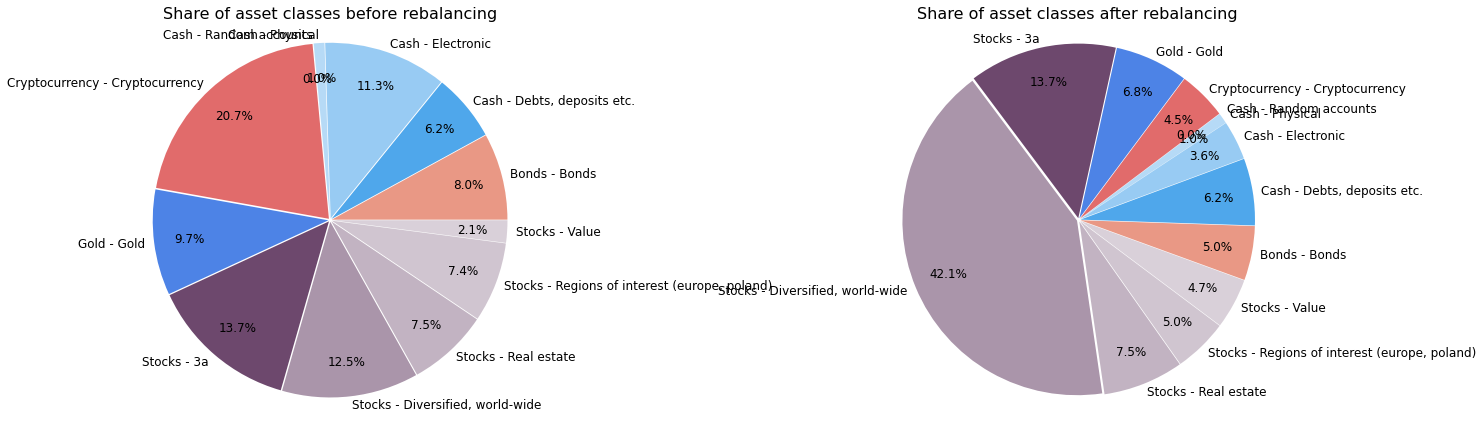

,Category,Subcategory,Asset,Action,Buy / Sell quantity,Value delta in PLN,Start value in PLN,End value in PLN
0,Stocks,"Diversified, world-wide",VANGUARD TOT WORLD STK ETF,Buy,251,"93,306.7","37,174.0","130,480.7"
1,Stocks,"Diversified, world-wide",Vanguard Value ETF,Buy,251,"114,562.0","45,642.2","160,204.3"
2,Stocks,Value,Broker 8,Buy,5686,"5,686.0","1,820.0","7,506.0"
3,Stocks,Value,Cash PLN,Buy,2843,"2,843.0","2,873.0","5,716.0"
4,Stocks,Value,Broker 1,Buy,1,"9,834.0","9,834.0","19,668.0"
5,Stocks,"Regions of interest (europe, poland)",iShares Trust iShares MSCI Pola,Sell,70,"4,985.8","7,122.5","2,136.8"
6,Stocks,"Regions of interest (europe, poland)",UBSETF SXI REAL ESTATE CHF DIS,Sell,34,"4,917.3","14,462.6","9,545.3"
7,Stocks,"Regions of interest (europe, poland)",Vanguard Total World Bond ETF,Sell,22,"6,646.5","30,211.3","23,564.8"
8,Bonds,Bonds,iSh Core SPI (CH) CHF Dis,Sell,37,"20,758.0","56,102.7","35,344.7"
9,Gold,Gold,UBS ETF GOLD,Sell,50,"20,708.2","41,416.4","20,708.2"


In [125]:
#Category and subcategfory to allocate any value left after rebalancing 
#due to lacking divisbility of certain assets
leftover_cat="Cash" #@param
leftover_subcat="Electronic" #@param

#That is a min value in your default currency from which 
#any rebalancing recommendation will be made
min_delta=1000 #@param
reb_style = "predefined" #@param

portfolio.rebalance(rebalancing_style=reb_style, leftover_cat=leftover_cat,
                    leftover_subcat=leftover_subcat, min_delta=min_delta)